In [33]:
from autogluon.tabular import TabularDataset, TabularPredictor
from fairlearn.datasets import fetch_adult, fetch_acs_income
from aif360.datasets import AdultDataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer
from sklearn.compose import (
    ColumnTransformer,
    make_column_selector,
    make_column_transformer,
)
from tqdm import tqdm

In [26]:
adult = fetch_adult()

target_map = {"<=50K": 0, ">50K": 1}
X = adult["data"].drop(columns="fnlwgt")

categorical_cols = X.select_dtypes(include=["category"]).columns
numerical_cols = X.select_dtypes(include=["int", "float"]).columns
X[categorical_cols] = X[categorical_cols].astype("object")

X.fillna("Missing", inplace=True)
y = adult["target"].map(target_map)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [27]:
from sklearn.preprocessing import StandardScaler


preprocessor = ColumnTransformer(
    [
        ("scale", StandardScaler(), numerical_cols),
        (
            "onehot",
            OneHotEncoder(handle_unknown="ignore", sparse_output=False),
            categorical_cols,
        ),
    ],
    remainder="passthrough",
)

In [28]:
from sklearn.ensemble import (
    RandomForestClassifier,
    HistGradientBoostingClassifier,
    GradientBoostingClassifier,
)
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

estimators = {
    "RandomForest": RandomForestClassifier(),
    "HistGB": HistGradientBoostingClassifier(),
    "GB": GradientBoostingClassifier(),
    "LogReg": LogisticRegression(),
}

In [ ]:
results = {}
metrics = ["f1", "accuracy", "precision", "recall", "roc_auc"]
for name, clf in estimators.items():

    pipeline = Pipeline(
        [
            ("preprocessor", preprocessor),
            ("classifier", clf),
        ]
    )
    scores = cross_validate(
        pipeline,
        X_train,
        y_train,
        scoring=metrics,
    )
    results.update({name: scores})

In [ ]:
results_mean = {}
for est_name, metrics in results.items():
    for metric_name, metric_values in metrics.items():
        average = metric_values.mean().round(2)
        if est_name not in results_mean:
            results_mean[est_name] = {}
        results_mean[est_name][metric_name] = average

In [53]:
pd.DataFrame(results_mean).T

,fit_time,score_time,test_f1,test_accuracy,test_precision,test_recall,test_roc_auc
RandomForest,2.42,0.25,0.66,0.85,0.71,0.62,0.89
HistGB,0.92,0.09,0.71,0.87,0.78,0.65,0.93
GB,5.70,0.06,0.69,0.87,0.79,0.61,0.92
LogReg,2.36,0.12,0.66,0.85,0.73,0.60,0.91


In [54]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)

test_results = {}

for name, clf in estimators.items():
    pipeline = Pipeline(
        [
            ("preprocessor", preprocessor),
            ("classifier", clf),
        ]
    )

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    y_proba = (
        pipeline.predict_proba(X_test)[:, 1]
        if hasattr(pipeline.named_steps["classifier"], "predict_proba")
        else None
    )

    test_scores = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
    }

    if y_proba is not None:
        test_scores["roc_auc"] = roc_auc_score(y_test, y_proba)

    test_results[name] = test_scores

In [58]:
pd.DataFrame(test_results).round(2).T

,accuracy,precision,recall,f1,roc_auc
RandomForest,0.85,0.71,0.63,0.67,0.90
HistGB,0.88,0.80,0.65,0.72,0.93
GB,0.87,0.80,0.59,0.68,0.92
LogReg,0.85,0.74,0.59,0.66,0.91


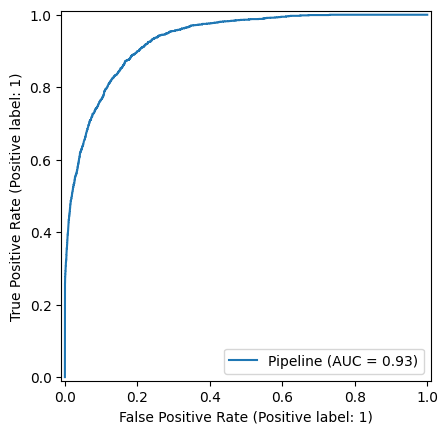

In [59]:
from sklearn.metrics import RocCurveDisplay

histgb = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", HistGradientBoostingClassifier()),
    ]
)

histgb.fit(X_train, y_train)
svc_disp = RocCurveDisplay.from_estimator(histgb, X_test, y_test)

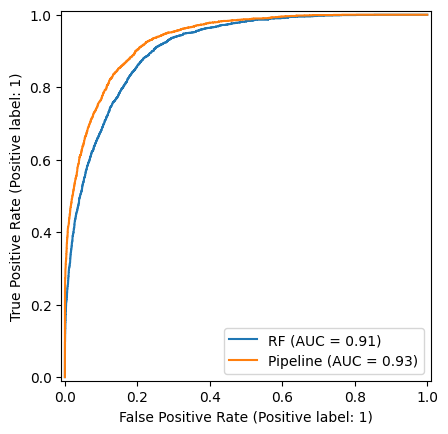

In [66]:
import matplotlib.pyplot as plt

rf = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", LogisticRegression()),
    ]
)

rf.fit(X_train, y_train)
ax = plt.gca()
RocCurveDisplay.from_estimator(rf, X_test, y_test, ax=ax, name="RF")
RocCurveDisplay.from_estimator(histgb, X_test, y_test, ax=ax)